[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/devdio/2025-ksci-agent/blob/main/01-basic-chatbot.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/devdio/2025-ksci-agent/blob/main/01-basic-chatbot.ipynb)

# 기본 챗봇 만들기

이 튜토리얼에서는 LLM을 사용하는 가장 간단한 기본적인 챗봇을 만들어 보겠습니다.   
그리고, 이 챗봇을 AI에이전트로 발전시켜 나가겠습니다.

## 1. 환경 설정

이 튜토리얼을 시작하기 전에 [OpenAI](https://platform.openai.com/api-keys),
[Anthropic](https://console.anthropic.com/settings/keys), 또는
[Google Gemini](https://ai.google.dev/gemini-api/docs/api-key) 등 **도구 호출 기능**을 지원하는 LLM에 연결할 수 있는지 확인하세요.

### `.env`파일 설정

LLM 호출과 도구 호출용 API키는 `.env` 파일에 설정되어 있습니다. `.env`파일의 형식은 아래 샘플을 참고하세요. 모든 항목의 API키가 필요한 것은 아니며, 사용하고자 하는 항목에 대해서만 API키를 설정하면 됩니다. 

이 튜토리얼에서는 OPENAI와 TAVILY 검색 서비스, 그리고 개발하는 에이전트의 입출력 메세지를 추적할 수 있는 LangSmith을 사용합니다. 

In [3]:
%%capture stdout

'''
# OPENAI API KEY
OPENAI_API_KEY={your-openai-key-here}

# GOOGLE API KEY
GOOGLE_GENAI_USE_VERTEXAI=FALSE
GOOGLE_API_KEY={your-project-name-here}

# ANTHROPIC API KEY
ANTHROPIC_API_KEY={your-anthropic-api-key-here}
 
# LANGCHAIN TOOL
TAVILY_API_KEY={your-tavily-key-here}

# LangSmith 설정
LANGCHAIN_TRACING_V2=false
LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
LANGCHAIN_API_KEY={your-langchain-api-key-here}
LANGCHAIN_PROJECT={your-project-name-here}
LANGSMITH_API_KEY={your-langsmith-key-here}
'''

### 패키지 설치
필요한 팩키지를 설치하세요.
> LangSmith를 사용하면 LangGraph로 빌드한 LLM 앱을 디버그, 테스트 및 모니터링할 수 있습니다.  
> 시작하는 방법에 대한 자세한 내용은 [LangSmith 문서](https://docs.smith.langchain.com)를 참조하세요.

In [4]:
!pip install -qU python-dotenv langgraph langsmith langchain-openai 

사용하는 API키가 정확히 설정되어 있는지 확인합니다.

In [ ]:
# 환경 변수 확인
from dotenv import load_dotenv
import getpass
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:10])

sk-proj-8x
tvly-dev-G


## 2. 전체 구조

![basic_chatbot_01](statics/01_basic_chatbot_01.png)

## 3. `StateGraph` 생성  
`StateGraph`는 어떤 **입력 상태(State)** 를 주면, **노드**들이 차례로 실행되면서 **상태(State)** 를 갱신하고, 정해진 경로대로 다음 **노드**로 넘어가는 구조입니다.

> Python 3.5 버전 이후부터 기본 모듈로 typing 모듈이 추가되어, **타입 힌트 (type hint)** 기능을 이용할 수 있게 되었다.  
> LLM을 활용한 어플리케이션의 개발에서는 LLM에게 코드의 정보를 전달할 수 있는 중요수단으로 사용되므로, 코드에 타입 힌트를 작성한다. 

In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# **입력 상태**
class State(TypedDict):
    # Messages는 "list" 타입을 가집니다. 
    # 주석에 있는 `add_messages`는 메시지를 덮어쓰는 것이 아니라 리스트에 추가하는 방식으로 작동합니다
    messages: Annotated[list, add_messages]

In [17]:
# `StateGraph` 생성
graph_builder = StateGraph(State)

그래프를 정의할 때 첫 번째 단계는 그래프의 `State`를 정의하는 것입니다.   
`State`에는 그래프의 스키마와 상태 업데이트를 처리하는 [reducer 함수](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)가 포함됩니다. 이 예제에서 `State`는 하나의 키인 `메시지`를 가진 `TypedDict`입니다. [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 함수는 목록을 덮어쓰는 대신 새 메시지를 목록에 추가하는 데 사용됩니다.   
Reducer가 없는 키는 이전 값을 덮어씁니다. State, Reducer에 대해 자세히 알아보려면 [LangGraph 참조 문서](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages)를 참조하세요.

## 4. 그래프 생성

`chatbot` 노드를 추가합니다. **노드**는 작업 단위를 나타내며 일반적으로 Python 함수로 구현합니다.

### 노드 정의

In [18]:
from langchain_openai import ChatOpenAI

def chatbot(state: State):
    # LLM 정의
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

모든 노드는 State를 입력으로 받아서 업데이트 된 State를 반환하는 방식이다.   
이는 모든 LangGraph 노드의 기본 패턴입니다.

### 노드 추가

In [19]:
# 첫 번째 인자는 고유한 노드 이름입니다.
# 두 번째 인자는 노드가 호출될 때마다 실행될 `함수`나 `객체`입니다.
graph_builder.add_node("chatbot", chatbot)

### `Entry 포인트` 추가

Graph가 시작될 때마다 작업의 시작 위치를 알려주는 지점을 추가합니다.

In [20]:
graph_builder.add_edge(START, "chatbot")

### `exit 포인트` 추가

In [21]:
graph_builder.add_edge("chatbot", END)

### 그래프 컴파일

그래프를 실행하기 전에 먼저 그래프를 컴파일해야 합니다. `compile()`함수를 호출하여 컴파일할 수 있습니다. 이렇게 하면 CompiledGraph상태를 호출할 수 있는 함수가 생성됩니다.

In [22]:
graph = graph_builder.compile()

### 그래프 시각화 (선택)

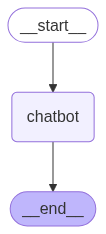

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 5. 챗봇 실행

In [24]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
            
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)
    except:
        pass

User:  지구의 둘레를 km단위로 알려줘


Assistant: 지구의 둘레는 약 40,075킬로미터입니다. 이는 적도 주위를 기준으로 한 측정값입니다. 극 주위의 둘레는 약 40,008킬로미터로, 지구가 완벽한 구형이 아니라 약간 편평한 형태를 가지고 있음을 나타냅니다.


User:  지구와 달 사이의 거리를 알려줘


Assistant: 지구와 달 사이의 평균 거리는 약 38,440킬로미터(약 23,600마일)입니다. 하지만 이 거리는 달의 궤도가 타원형이기 때문에 변동이 있을 수 있습니다. 달이 지구에 가장 가까워질 때는 약 36,000킬로미터(약 22,400마일)까지 가까워질 수 있고, 가장 멀어질 때는 약 40,000킬로미터(약 25,000마일)까지 멀어질 수 있습니다.


User:  exit


Goodbye!


## 6. 전체 코드

In [ ]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

## END